In [1]:
from models.vit_lit import VitModel
from models.modeling import CONFIGS
from utils.data_utils import get_loader
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5)
import os
import glob
plt.rcParams['figure.dpi'] = 300

In [2]:
import argparse
import shlex
def main(cmd=''):
    parser = argparse.ArgumentParser()
    # Required parameters
    parser.add_argument("--name", required=True,
                        help="Name of this run. Used for monitoring.")
    parser.add_argument("--dataset", choices=["cifar10", "cifar100"], default="cifar10",
                        help="Which downstream task.")
    parser.add_argument("--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16",
                                                 "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"],
                        default="ViT-B_16",
                        help="Which variant to use.")
    parser.add_argument("--pretrained_dir", type=str, default="checkpoint/ViT-B_16.npz",
                        help="Where to search for pretrained ViT models.")
    parser.add_argument("--output_dir", default="output", type=str,
                        help="The output directory where checkpoints will be written.")

    parser.add_argument("--img_size", default=224, type=int,
                        help="Resolution size")
    parser.add_argument("--train_batch_size", default=512, type=int,
                        help="Total batch size for training.")
    parser.add_argument("--eval_batch_size", default=64, type=int,
                        help="Total batch size for eval.")
    parser.add_argument("--eval_every", default=100, type=int,
                        help="Run prediction on validation set every so many steps."
                             "Will always run one evaluation at the end of training.")

    parser.add_argument("--learning_rate", default=3e-2, type=float,
                        help="The initial learning rate for SGD.")
    parser.add_argument("--weight_decay", default=0, type=float,
                        help="Weight deay if we apply some.")
    parser.add_argument("--num_steps", default=10000, type=int,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--decay_type", choices=["cosine", "linear"], default="cosine",
                        help="How to decay the learning rate.")
    parser.add_argument("--warmup_epochs", default=2, type=int,
                        help="Epochs of training to perform learning rate warmup for.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float,
                        help="Max gradient norm.")

    parser.add_argument("--local_rank", type=int, default=-1,
                        help="local_rank for distributed training on gpus")
    parser.add_argument('--seed', type=int, default=42,
                        help="random seed for initialization")
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    parser.add_argument('--fp16', action='store_true',
                        help="Whether to use 16-bit float precision instead of 32-bit")
    parser.add_argument('--fp16_opt_level', type=str, default='O2',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument('--loss_scale', type=float, default=0,
                        help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                             "0 (default value): dynamic loss scaling.\n"
                             "Positive power of 2: static loss scaling value.\n")
    if cmd != '':
        args = parser.parse_args(cmd)
    else:
        args = parser.parse_args()

    return args 

args = main(shlex.split('--name cifar10-100_500_rank64  --dataset cifar10 --model_type ViT-B_16 --pretrained_dir checkpoint/ViT-B_16.npz --fp16 --fp16_opt_level O2 --gradient_accumulation_steps 15 --train_batch_size 64  --num_steps 2000'))

In [3]:
from utils.data_utils import get_loader
train_loader, test_loader = get_loader(args)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
av_list = []
for mh in [55,50,45,3,1]:
    path = f'runs/cifar10-100_500_{mh}/version_0/checkpoints'
    path = glob.glob(f'{path}/*') # * means all if need specific format then *.csv
    file = max(path, key=os.path.getctime)
    model = VitModel.load_from_checkpoint(file, strict=False)
    layer = 5
    head = 0
    res = []
    for x in train_loader:
        input = x[0]
        _, A = model.model.transformer(input)
        attention = A[layer].detach().numpy()
        s = np.linalg.svd(attention[:,head], compute_uv=False)
        res.append(s)
        if len(res)>5:
            break
    res = np.array(res)
    res = res.reshape(-1,197)
    res = res[:,:64]/197
    average = np.mean(res, axis=0)
    av_list.append(average)

In [ ]:
m = np.array([1,2,3,5, 6, 7, 8, 10, 14, 16, 20, 24,25,30, 32, 35, 40, 50, 64])
e = np.array([1.75, 1.61, 1.58, 1.50, 1.48, 1.47, 1.45, 1.43, 1.39 ,1.39, 1.38, 1.34, 1.34, 1.32, 1.32, 1.31, 1.31, 1.30, 1.29])

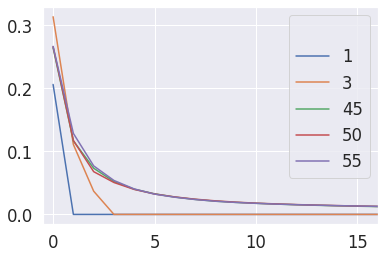

In [12]:
# plt.plot(m,e)
plt.plot(av_list[4], label='1')
plt.plot(av_list[3], label='3')
plt.plot(av_list[2], label='45')
plt.plot(av_list[1], label='50')
plt.plot(av_list[0], label='55')
plt.xlim((-0.5,16))
# plt.plot(range(3,65), np.array([np.sqrt(np.sum(av_list[0][i:]**2)) for i in range(64)])[2:]+1.5, label='64')
plt.legend(title="     ")
plt.savefig('b.png', dpi=800)